In [3]:
!pip install pandas numpy pillow tqdm torch torchvision transformers scikit-learn xgboost matplotlib



  Using cached torchvision-0.22.1-cp310-cp310-win_amd64.whl.metadata (6.1 kB)
  Using cached transformers-4.52.4-py3-none-any.whl.metadata (38 kB)
  Using cached matplotlib-3.10.3-cp310-cp310-win_amd64.whl.metadata (11 kB)
Using cached torchvision-0.22.1-cp310-cp310-win_amd64.whl (1.7 MB)
Using cached transformers-4.52.4-py3-none-any.whl (10.5 MB)
Using cached matplotlib-3.10.3-cp310-cp310-win_amd64.whl (8.1 MB)

   ---------------------------------------- 0/3 [matplotlib]
   ---------------------------------------- 0/3 [matplotlib]
   ---------------------------------------- 0/3 [matplotlib]
   ---------------------------------------- 0/3 [matplotlib]
   ---------------------------------------- 0/3 [matplotlib]
   ---------------------------------------- 0/3 [matplotlib]
   ---------------------------------------- 0/3 [matplotlib]
   ---------------------------------------- 0/3 [matplotlib]
   ---------------------------------------- 0/3 [matplotlib]
   -------------------------------

In [5]:
! pip install pandas

In [8]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

^C


Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 0.0/2.4 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 GB 52.4 MB/s eta 0:00:47
     ---------------------------------------- 0.0/2.4 GB 44.2 MB/s eta 0:00:56
     ---------------------------------------- 0.0/2.4 GB 52.1 MB/s eta 0:00:47
      --------------------------------------- 0.0/2.4 GB 56.8 MB/s eta 0:00:43
      --------------------------------------- 0.1/2.4 GB 58.5 MB/s eta 0:00:41
     - -------------------------------------- 0.1/2.4 GB 59.6 MB/s eta 0:00:40
     - -------------------------------------- 0.1/2.4 GB 60.9 MB/s eta 0:00:39
     - -------------------------------------- 0.1/2.4 GB 61.7 MB/s eta 0:00:39
     - -------------------------------------- 0.1/2.4 GB 62.6 MB/s eta 0:00:38
     -- ------------------------------------- 0.1/2.4 GB 64.1 MB/s eta 0:00:37
     -- ------------------------------------- 0.1/2.4 GB 64.3 MB/s eta 0:00:36
 

In [7]:
!pip uninstall torch torchvision torchaudio -y

Found existing installation: torch 2.7.1
Uninstalling torch-2.7.1:
  Successfully uninstalled torch-2.7.1
Found existing installation: torchvision 0.22.1
Uninstalling torchvision-0.22.1:
  Successfully uninstalled torchvision-0.22.1


You can safely remove it manually.
You can safely remove it manually.


In [3]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)


In [2]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


CUDA Available: True
Device: NVIDIA GeForce RTX 2050


In [3]:
import os
import joblib
import warnings
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm  # Better for Jupyter

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)


d:\PES\Summer_Intership\Instagram\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda


In [4]:
df = pd.read_csv('5130.csv')
df = df.dropna(subset=['username', 'followersCount', 'followsCount']).reset_index(drop=True)

df['followersCount'] = df['followersCount'].fillna(0)
df['followsCount'] = df['followsCount'].fillna(0)

scaler = StandardScaler()
follow_features = scaler.fit_transform(df[['followersCount', 'followsCount']])


In [5]:
from tqdm import tqdm
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

df['text_combined'] = df['username'].fillna('') + ' ' + df['biography'].fillna('')

class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        return self.texts[idx]

class TextCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def __call__(self, batch):
        return self.tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=32)

text_dataset = TextDataset(df['text_combined'].tolist())
text_loader = DataLoader(text_dataset, batch_size=32, collate_fn=TextCollator(tokenizer))

text_features = []
with torch.no_grad():
    for batch in tqdm(text_loader, desc="🔠 BERT Embeddings"):
        batch = {k: v.to(device) for k, v in batch.items()}
        output = bert_model(**batch)
        text_features.append(output.pooler_output.cpu().numpy())

text_features = np.vstack(text_features)


🔠 BERT Embeddings: 100%|██████████| 161/161 [00:14<00:00, 10.74it/s]


In [6]:
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1]).to(device)
resnet.eval()

img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image_dir = 'Img_2565'

def extract_image_features(usernames):
    features = []
    for username in tqdm(usernames, desc="🖼️ ResNet Features"):
        img_path = os.path.join(image_dir, f"{username}.jpg")
        if os.path.exists(img_path):
            try:
                img = Image.open(img_path).convert('RGB')
                img_tensor = img_transform(img).unsqueeze(0).to(device)
                with torch.no_grad():
                    feat = resnet(img_tensor).squeeze().cpu().numpy()
            except:
                feat = np.zeros(2048)
        else:
            feat = np.zeros(2048)
        features.append(feat)
    return np.vstack(features)

image_features = extract_image_features(df['username'])


🖼️ ResNet Features: 100%|██████████| 5128/5128 [04:15<00:00, 20.10it/s]


In [7]:
combined_features = np.hstack([text_features, image_features, follow_features])
labels = df['fake_account'].values

X_train, X_test, y_train, y_test = train_test_split(
    combined_features, labels, test_size=0.2, random_state=42
)


In [8]:
clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    tree_method='gpu_hist' if torch.cuda.is_available() else 'auto',
    predictor='gpu_predictor' if torch.cuda.is_available() else 'auto',
    use_label_encoder=False,
    eval_metric='logloss'
)

clf.fit(X_train, y_train)

joblib.dump(clf, "fake_account_detector.pkl")
print("💾 Model saved as 'fake_account_detector.pkl'")


💾 Model saved as 'fake_account_detector.pkl'


📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       517
           1       1.00      1.00      1.00       509

    accuracy                           1.00      1026
   macro avg       1.00      1.00      1.00      1026
weighted avg       1.00      1.00      1.00      1026



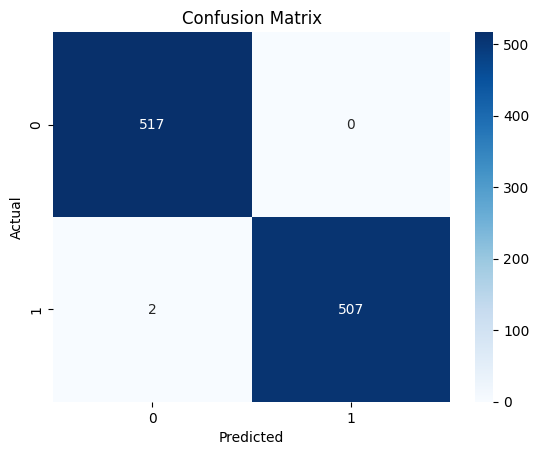

In [9]:
y_pred = clf.predict(X_test)
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, combined_features, labels, cv=skf, scoring='accuracy')

print("✅ CV Accuracies:", cv_scores)
print("📊 Mean Accuracy:", np.mean(cv_scores).round(4))
print("📉 Std Dev:", np.std(cv_scores).round(4))


✅ CV Accuracies: [0.99836066 0.99672131 0.99836066 1.         0.99836066]
📊 Mean Accuracy: 0.9984
📉 Std Dev: 0.001


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = clf.predict(X_test)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("✅ Accuracy:", round(accuracy_score(y_test, y_pred), 4))


📊 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       331
           1     1.0000    1.0000    1.0000       279

    accuracy                         1.0000       610
   macro avg     1.0000    1.0000    1.0000       610
weighted avg     1.0000    1.0000    1.0000       610

✅ Accuracy: 1.0


In [19]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(df))
train_idx, test_idx, y_train, y_test = train_test_split(
    indices, labels, test_size=0.2, random_state=42, stratify=labels
)

X_train = combined_features[train_idx]
X_test = combined_features[test_idx]


train_usernames = set(df.iloc[train_idx]['username'])
test_usernames = set(df.iloc[test_idx]['username'])

common_users = train_usernames & test_usernames
print("🔁 Common usernames in train & test:", len(common_users))


🔁 Common usernames in train & test: 0


In [20]:
def predict_single_profile(username, bio, followers, follows, img_path):
    # Prepare text
    text = username + " " + bio
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=32).to(device)
    with torch.no_grad():
        text_feat = bert_model(**tokens).pooler_output.cpu().numpy()

    # Prepare image
    if os.path.exists(img_path):
        try:
            img = Image.open(img_path).convert('RGB')
            img_tensor = img_transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                img_feat = resnet(img_tensor).squeeze().cpu().numpy()
        except:
            img_feat = np.zeros(2048)
    else:
        img_feat = np.zeros(2048)

    # Prepare numeric features
    follow_feat = scaler.transform([[followers, follows]])

    # Combine
    final_feat = np.hstack([text_feat, img_feat.reshape(1, -1), follow_feat])
    pred = clf.predict(final_feat)[0]
    return "✅ Real" if pred == 0 else "⚠️ Fake"


In [21]:
predict_single_profile("insta_beauty001", "DM for promotions 💋💰", 45, 800, "Images_Dataset/insta_beauty001.jpg")


'⚠️ Fake'

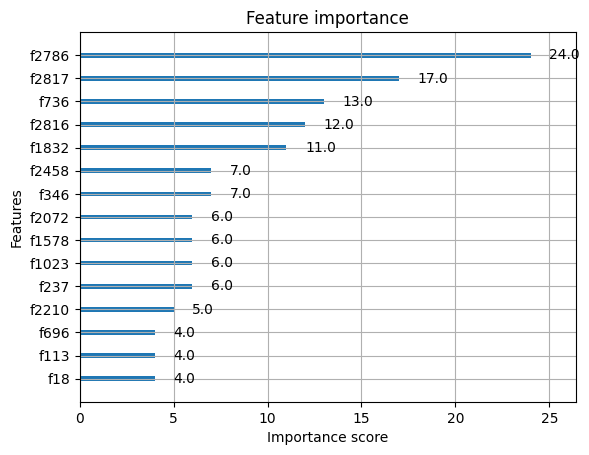

In [22]:
xgb.plot_importance(clf, max_num_features=15)
plt.show()

In [23]:
def predict_profile(username, bio, followers, follows, img_path=None):
    # ---- Text Features ----
    text = username + " " + bio
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=32).to(device)
    with torch.no_grad():
        text_feat = bert_model(**tokens).pooler_output.cpu().numpy()

    # ---- Image Features ----
    if img_path and os.path.exists(img_path):
        try:
            img = Image.open(img_path).convert('RGB')
            img_tensor = img_transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                img_feat = resnet(img_tensor).squeeze().cpu().numpy()
        except:
            img_feat = np.zeros(2048)
    else:
        img_feat = np.zeros(2048)

    # ---- Numeric Features ----
    follow_feat = scaler.transform([[followers, follows]])

    # ---- Combine All ----
    combined = np.hstack([text_feat, img_feat.reshape(1, -1), follow_feat])
    pred = clf.predict(combined)[0]
    return "✅ Real" if pred == 0 else "⚠️ Fake"


In [24]:
edge_cases = [
    # 1. Looks real, high followers
    {"username": "elonmusk", "bio": "CEO, engineer, dogecoin enthusiast", "followers": 20_000_000, "follows": 100, "img": None},

    # 2. Looks fake, 0 followers/follows
    {"username": "prettygrl889", "bio": "🔥DM for collab🔥", "followers": 0, "follows": 0, "img": None},

    # 3. Suspicious name, high followers
    {"username": "free_giveaway2024", "bio": "Win an iPhone NOW!!!", "followers": 50000, "follows": 1000, "img": None},

    # 4. Empty bio and generic username
    {"username": "user1234", "bio": "", "followers": 150, "follows": 100, "img": None},

    # 5. Looks fake but has image
    {"username": "sexy_dreamxoxo", "bio": "👠💄 only fans 👉 DM me", "followers": 5, "follows": 300, "img": None},
]


In [25]:
for profile in edge_cases:
    result = predict_profile(
        username=profile['username'],
        bio=profile['bio'],
        followers=profile['followers'],
        follows=profile['follows'],
        img_path=profile['img']  # Optional image path
    )
    print(f"{profile['username']}: {result}")


elonmusk: ✅ Real
prettygrl889: ✅ Real
free_giveaway2024: ✅ Real
user1234: ✅ Real
sexy_dreamxoxo: ✅ Real


In [1]:
print("CUDA Available:", torch.cuda.is_available())
print("Using device:", device)


NameError: name 'torch' is not defined

In [6]:
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from torch import nn
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import xgboost as xgb
import os
import warnings
warnings.filterwarnings("ignore")

# ========== CUDA SETUP ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ CUDA Available:", torch.cuda.is_available())
print("💻 Using Device:", device)

# ========== LOAD & CLEAN CSV ==========
df = pd.read_csv('Dataset_1526x2.csv')
df = df.dropna(subset=['username', 'followersCount', 'followsCount'])
df = df.reset_index(drop=True)

df['followersCount'] = df['followersCount'].fillna(0)
df['followsCount'] = df['followsCount'].fillna(0)

# ========== SCALE NUMERIC FEATURES ==========
scaler = StandardScaler()
follow_features = scaler.fit_transform(df[['followersCount', 'followsCount']])

# ========== BERT TEXT FEATURES ==========
print("🚀 Loading BERT model on GPU...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

def get_bert_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=32)
    tokens = {key: val.to(device) for key, val in tokens.items()}
    with torch.no_grad():
        output = bert_model(**tokens)
    return output.pooler_output[0].cpu().numpy()

df['text_combined'] = df['username'].fillna('') + ' ' + df['biography'].fillna('')

text_features = []
for txt in tqdm(df['text_combined'], desc="🔤 Extracting BERT Features (GPU)"):
    emb = get_bert_embedding(txt)
    text_features.append(emb)
text_features = np.vstack(text_features)

# ========== RESNET IMAGE FEATURES ==========
print("🖼️ Loading ResNet model on GPU...")
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1]).to(device)
resnet.eval()

# Image transforms
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img_aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Set your image folder
image_dir = 'Images_Data'

def get_image_feature_from_file(username, augment=True, repeats=3):
    try:
        img_path = os.path.join(image_dir, f"{username}.jpg")
        if not os.path.exists(img_path):
            return np.zeros(2048)
        img = Image.open(img_path).convert('RGB')

        feats = []
        for _ in range(repeats):
            transform = img_aug_transform if augment else img_transform
            img_tensor = transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                feature = resnet(img_tensor).squeeze().cpu().numpy()
                feats.append(feature)
        return np.mean(feats, axis=0)
    except Exception as e:
        return np.zeros(2048)

image_features = []
for username in tqdm(df['username'], desc="🖼️ Extracting Image Features (ResNet50 + GPU)"):
    feat = get_image_feature_from_file(username, augment=True, repeats=3)
    image_features.append(feat)
image_features = np.vstack(image_features)

# ========== COMBINE FEATURES ==========
combined_features = np.hstack([text_features, image_features, follow_features])
labels = df['fake_account'].values  # Must be binary 0 or 1

# ========== SPLIT DATA ==========
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

# ========== XGBOOST ON GPU ==========
print("🚀 Training XGBoost on GPU...")
clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='gpu_hist',       # 🧠 Enable GPU
    predictor='gpu_predictor'     # 🧠 Enable GPU
)

clf.fit(X_train, y_train)

# ========== EVALUATION ==========
y_pred = clf.predict(X_test)
print("\n✅ Classification Report:\n")
print(classification_report(y_test, y_pred))


✅ CUDA Available: True
💻 Using Device: cuda
🚀 Loading BERT model on GPU...



























































































































































































































🔤 Extracting BERT Features (GPU): 100%|██████████| 3050/3050 [00:23<00:00, 132.13it/s]


🖼️ Loading ResNet model on GPU...


🚀 Training XGBoost on GPU...

✅ Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       294
           1       1.00      1.00      1.00       316

    accuracy                           1.00       610
   macro avg       1.00      1.00      1.00       610
weighted avg       1.00      1.00      1.00       610



In [7]:
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from torch import nn
from torchvision import models, transforms
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import xgboost as xgb
import os
import warnings
warnings.filterwarnings("ignore")

# =================== Device Setup ===================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ CUDA Available:", torch.cuda.is_available())
print("💻 Using Device:", device)

# =================== Load & Clean CSV ===================
df = pd.read_csv('Dataset_1526x2.csv')
df = df.dropna(subset=['username', 'followersCount', 'followsCount'])
df = df.reset_index(drop=True)
df['followersCount'] = df['followersCount'].fillna(0)
df['followsCount'] = df['followsCount'].fillna(0)

# =================== Scale Numeric Features ===================
scaler = StandardScaler()
follow_features = scaler.fit_transform(df[['followersCount', 'followsCount']])

# =================== DistilBERT Text Embeddings ===================
print("🚀 Loading DistilBERT model...")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
bert_model.eval()

def get_bert_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=32)
    tokens = {key: val.to(device) for key, val in tokens.items()}
    with torch.no_grad():
        output = bert_model(**tokens)
    return output.last_hidden_state[:, 0, :].cpu().numpy()[0]  # [CLS] token

df['text_combined'] = df['username'].fillna('') + ' ' + df['biography'].fillna('')
text_features = []
for txt in tqdm(df['text_combined'], desc="🔤 BERT Embeddings"):
    text_features.append(get_bert_embedding(txt))
text_features = np.vstack(text_features)  # Shape: (N, 768)

# =================== MobileNetV2 Image Features ===================
print("🖼️ Loading MobileNetV2...")
mobilenet = models.mobilenet_v2(pretrained=True)
resnet = nn.Sequential(mobilenet.features, nn.AdaptiveAvgPool2d((1, 1))).to(device)
resnet.eval()

# Image transforms
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img_aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image_dir = 'Images_Data'

def get_image_feature_from_file(username, augment=True, repeats=3):
    try:
        img_path = os.path.join(image_dir, f"{username}.jpg")
        if not os.path.exists(img_path):
            return np.zeros(1280)
        img = Image.open(img_path).convert('RGB')
        feats = []
        for _ in range(repeats):
            transform = img_aug_transform if augment else img_transform
            img_tensor = transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                feature = resnet(img_tensor).squeeze().cpu().numpy()
                feats.append(feature)
        return np.mean(feats, axis=0)
    except:
        return np.zeros(1280)

image_features = []
for username in tqdm(df['username'], desc="🖼️ MobileNetV2 Image Features"):
    image_features.append(get_image_feature_from_file(username, augment=True, repeats=3))
image_features = np.vstack(image_features)  # Shape: (N, 1280)

# =================== Combine All Features ===================
combined_features = np.hstack([text_features, image_features, follow_features])  # Shape: (N, 768+1280+2)
labels = df['fake_account'].values  # Must be binary (0 or 1)

# =================== Train/Test Split ===================
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

# =================== XGBoost (GPU) ===================
print("🔥 Training XGBoost on GPU...")
clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)
clf.fit(X_train, y_train)

# =================== Evaluate ===================
y_pred = clf.predict(X_test)
print("\n✅ Classification Report:\n")
print(classification_report(y_test, y_pred))


✅ CUDA Available: True
💻 Using Device: cuda
🚀 Loading DistilBERT model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`

























































































































🔤 BERT Embeddings: 100%|██████████| 3050/3050 [00:12<00:00, 243.92it/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\santo/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


🖼️ Loading MobileNetV2...








100%|██████████| 13.6M/13.6M [00:00<00:00, 24.3MB/s]















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































🔥 Training XGBoost on GPU...

✅ Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       294
           1       0.99      1.00      1.00       316

    accuracy                           1.00       610
   macro avg       1.00      1.00      1.00       610
weighted avg       1.00      1.00      1.00       610



In [8]:
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from torch import nn
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import xgboost as xgb
import os
import warnings
warnings.filterwarnings("ignore")

# ================== CUDA DEVICE ==================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ CUDA Available:", torch.cuda.is_available())
print("💻 Using Device:", device)

# ================== Load & Clean CSV ==================
df = pd.read_csv('Dataset_1526x2.csv')
df = df.dropna(subset=['username', 'followersCount', 'followsCount'])
df = df.reset_index(drop=True)

df['followersCount'] = df['followersCount'].fillna(0)
df['followsCount'] = df['followsCount'].fillna(0)

# ================== Scale Numeric Features ==================
scaler = StandardScaler()
follow_features = scaler.fit_transform(df[['followersCount', 'followsCount']])

# ================== BERT for Text Features (on GPU) ==================
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

def get_bert_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=32)
    tokens = {k: v.to(device) for k, v in tokens.items()}
    with torch.no_grad():
        output = bert_model(**tokens)
    return output.pooler_output[0].cpu().numpy()

df['text_combined'] = df['username'].fillna('') + ' ' + df['biography'].fillna('')
text_features = np.vstack([
    get_bert_embedding(txt) for txt in tqdm(df['text_combined'], desc="🔤 BERT Text Embeddings (GPU)")
])

# ================== ResNet for Image Features (on GPU) ==================
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1]).to(device)
resnet.eval()

# Image transforms
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img_aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Path to image folder
image_dir = 'Images_Data'  # 🔁 Replace this with your actual path

def get_image_feature_from_file(username, augment=True, repeats=3):
    try:
        img_path = os.path.join(image_dir, f"{username}.jpg")
        if not os.path.exists(img_path):
            return np.zeros(2048)
        img = Image.open(img_path).convert('RGB')

        feats = []
        for _ in range(repeats):
            transform = img_aug_transform if augment else img_transform
            img_tensor = transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                feature = resnet(img_tensor).squeeze().cpu().numpy()
                feats.append(feature)
        return np.mean(feats, axis=0)
    except Exception as e:
        return np.zeros(2048)

# Extract image features with augmentation (on GPU)
image_features = np.vstack([
    get_image_feature_from_file(username, augment=True, repeats=3)
    for username in tqdm(df['username'], desc="🖼️ Image Features (ResNet + GPU)")
])

# ================== Combine All Features ==================
combined_features = np.hstack([text_features, image_features, follow_features])
labels = df['fake_account'].values  # Ensure this column exists and is binary (0 or 1)

# ================== Train/Test Split ==================
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, labels, test_size=0.2, random_state=42
)

# ================== XGBoost on GPU ==================
clf = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=3,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='gpu_hist',       # Enable GPU training
    predictor='gpu_predictor'     # Enable GPU inference
)
clf.fit(X_train, y_train)

# ================== Evaluate ==================
y_pred = clf.predict(X_test)
print("\n✅ Classification Report:\n")
print(classification_report(y_test, y_pred))


✅ CUDA Available: True
💻 Using Device: cuda







































































































































































































































BERT Text Embeddings:  26%|██▌       | 791/3050 [34:40<1:39:02,  2.63s/it]


















































🖼️ Image Features (ResNet + GPU): 100%|██████████| 3050/3050 [03:11<00:00, 15.94it/s]



✅ Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       294
           1       1.00      1.00      1.00       316

    accuracy                           1.00       610
   macro avg       1.00      1.00      1.00       610
weighted avg       1.00      1.00      1.00       610



In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from torch import nn
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb
import os
import warnings
warnings.filterwarnings("ignore")

# ========== Device Setup ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ========== Load Data ==========
df = pd.read_csv('5130.csv')
df = df.dropna(subset=['username', 'followsCount', 'followersCount'])
df = df.reset_index(drop=True)

# ========== BERT Text Embeddings ==========
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

def get_bert_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=32).to(device)
    with torch.no_grad():
        output = bert_model(**tokens)
    return output.pooler_output[0].cpu().numpy()  # move to CPU before numpy

df['text_combined'] = df['username'].fillna('') + ' ' + df['biography'].fillna('')
text_features = np.vstack([get_bert_embedding(txt) for txt in tqdm(df['text_combined'], desc="BERT Text Embeddings")])

# ========== ResNet Feature Extraction with Augmentation ==========
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(
    *list(resnet.children())[:-1],
    nn.Flatten(),
    nn.Linear(2048, 256),
    nn.ReLU()
).to(device)
resnet.eval()

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

img_aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

image_dir = "Img_2565"

def get_augmented_image_feature(username, repeats=3):
    try:
        img_path = os.path.join(image_dir, f"{username}.jpg")
        if not os.path.exists(img_path):
            return np.zeros(256)
        img = Image.open(img_path).convert('RGB')

        features = []
        for _ in range(repeats):
            transformed = img_aug_transform(img)
            transformed = transformed.unsqueeze(0).to(device)  # Move to device
            with torch.no_grad():
                feature = resnet(transformed).squeeze().cpu().numpy()
                features.append(feature)
        return np.mean(features, axis=0)
    except:
        return np.zeros(256)

image_features = np.vstack([
    get_augmented_image_feature(username)
    for username in tqdm(df['username'], desc="Image Features with Augmentation")
])

# ========== Combine Features ==========
combined_features = np.hstack([text_features, image_features])

labels = df['fake_account'].values

# ========== Train/Test Split & XGBoost ==========
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

clf = xgb.XGBClassifier(n_estimators=50, max_depth=3, use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist')
clf.fit(X_train, y_train)

# ========== Evaluate ==========
y_pred = clf.predict(X_test)
print("\n✅ Classification Report:\n")
print(classification_report(y_test, y_pred))


d:\PES\Summer_Intership\Instagram\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Using device: cuda


Image Features with Augmentation: 100%|██████████| 5128/5128 [06:26<00:00, 13.26it/s]



✅ Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       517
           1       0.99      0.99      0.99       509

    accuracy                           0.99      1026
   macro avg       0.99      0.99      0.99      1026
weighted avg       0.99      0.99      0.99      1026



In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score

# ========== Cross-Validation Setup ==========
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_preds = []
all_trues = []

for train_index, test_index in skf.split(combined_features, labels):
    print(f"\n🔁 Fold {fold}:")

    X_train, X_test = combined_features[train_index], combined_features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    clf = xgb.XGBClassifier(
        n_estimators=50,
        max_depth=3,
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='gpu_hist',
        predictor='gpu_predictor'
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))

    all_preds.extend(y_pred)
    all_trues.extend(y_test)

    fold += 1

# ========== Overall Evaluation ==========
print("\n🎯 Overall Cross-Validated Performance:")
print(classification_report(all_trues, all_preds))



🔁 Fold 1:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       513
           1       0.99      0.99      0.99       513

    accuracy                           0.99      1026
   macro avg       0.99      0.99      0.99      1026
weighted avg       0.99      0.99      0.99      1026


🔁 Fold 2:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       513
           1       0.99      0.99      0.99       513

    accuracy                           0.99      1026
   macro avg       0.99      0.99      0.99      1026
weighted avg       0.99      0.99      0.99      1026


🔁 Fold 3:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       513
           1       0.99      1.00      1.00       513

    accuracy                           1.00      1026
   macro avg       1.00      1.00      1.00      1026
weighted avg       1.00      1.00      1.

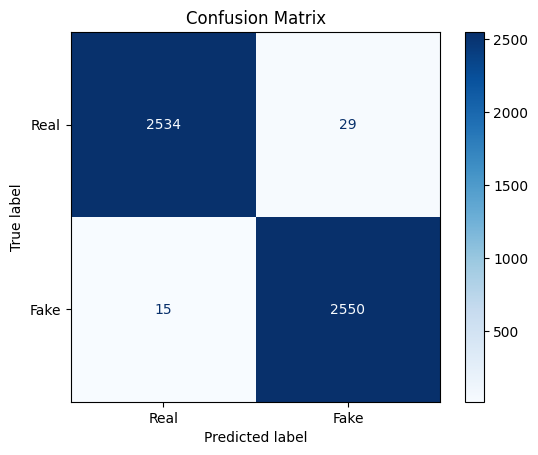

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_trues, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [8]:
from PIL import Image
import numpy as np
import torch

# Image preprocessing (fix)
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# 🔍 Sample inputs
sample_text = "appusuhasms33  Navodayan PESU'26 "
sample_img_path = "Suhas/appusuhasms33.jpg"

# 1. BERT embedding
text_input = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True, max_length=32).to(device)
with torch.no_grad():
    text_feature = bert_model(**text_input).pooler_output[0].cpu().numpy()

# 2. ResNet image embedding
img = Image.open(sample_img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)
with torch.no_grad():
    img_feature = resnet(img_tensor).squeeze().cpu().numpy()

# 3. Combine features and predict
final_input = np.hstack([text_feature, img_feature]).reshape(1, -1)
prediction = clf.predict(final_input)

print("✅ Prediction:", "FAKE" if prediction[0] == 1 else "REAL")


✅ Prediction: REAL


In [1]:
from PIL import Image
import numpy as np
import torch

# Image preprocessing (fix)
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# 🔍 Sample inputs
sample_text = "kira65rk  Ã°Å¸â€˜â€¹ I'm Noah | Ã¢Å“Â¨ | traveling lover "
sample_img_path = "Images_Data/kira65rk.jpg"

# 1. BERT embedding
text_input = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True, max_length=32).to(device)
with torch.no_grad():
    text_feature = bert_model(**text_input).pooler_output[0].cpu().numpy()

# 2. ResNet image embedding
img = Image.open(sample_img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)
with torch.no_grad():
    img_feature = resnet(img_tensor).squeeze().cpu().numpy()

# 3. Combine features and predict
final_input = np.hstack([text_feature, img_feature]).reshape(1, -1)
prediction = clf.predict(final_input)

print("✅ Prediction:", "FAKE" if prediction[0] == 1 else "REAL")


NameError: name 'transforms' is not defined

Random Forest

In [4]:
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from torch import nn
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier  # ✅ Replace XGBoost
from sklearn.preprocessing import StandardScaler
import os
import warnings
warnings.filterwarnings("ignore")

# ========== Device Setup ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ========== Load Data ==========
df = pd.read_csv('5130.csv')
df = df.dropna(subset=['username', 'followsCount', 'followersCount'])
df = df.reset_index(drop=True)

# ========== BERT Text Embeddings ==========
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

def get_bert_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=32).to(device)
    with torch.no_grad():
        output = bert_model(**tokens)
    return output.pooler_output[0].cpu().numpy()

df['text_combined'] = df['username'].fillna('') + ' ' + df['biography'].fillna('')
text_features = np.vstack([get_bert_embedding(txt) for txt in tqdm(df['text_combined'], desc="BERT Text Embeddings")])

# ========== ResNet Feature Extraction ==========
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(
    *list(resnet.children())[:-1],
    nn.Flatten(),
    nn.Linear(2048, 256),
    nn.ReLU()
).to(device)
resnet.eval()

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

img_aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

image_dir = "Img_2565"

def get_augmented_image_feature(username, repeats=3):
    try:
        img_path = os.path.join(image_dir, f"{username}.jpg")
        if not os.path.exists(img_path):
            return np.zeros(256)
        img = Image.open(img_path).convert('RGB')

        features = []
        for _ in range(repeats):
            transformed = img_aug_transform(img)
            transformed = transformed.unsqueeze(0).to(device)
            with torch.no_grad():
                feature = resnet(transformed).squeeze().cpu().numpy()
                features.append(feature)
        return np.mean(features, axis=0)
    except:
        return np.zeros(256)

image_features = np.vstack([
    get_augmented_image_feature(username)
    for username in tqdm(df['username'], desc="Image Features with Augmentation")
])

# ========== Combine & Scale Features ==========
combined_features = np.hstack([text_features, image_features])
labels = df['fake_account'].values

scaler = StandardScaler()
combined_features = scaler.fit_transform(combined_features)

# ========== Train/Test Split ==========
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

# ========== Train Random Forest ==========
clf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# ========== Evaluate ==========
y_pred = clf.predict(X_test)
print("\n✅ Classification Report (Random Forest):\n")
print(classification_report(y_test, y_pred))


✅ Using device: cuda


Image Features with Augmentation: 100%|██████████| 5128/5128 [05:40<00:00, 15.04it/s]



✅ Classification Report (Random Forest):

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       517
           1       0.95      0.98      0.96       509

    accuracy                           0.96      1026
   macro avg       0.96      0.96      0.96      1026
weighted avg       0.96      0.96      0.96      1026



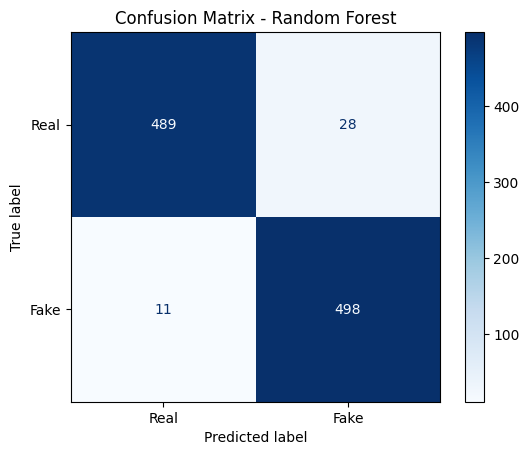

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Random Forest")
plt.show()
